In [68]:
import numpy as np
import torch
from torch.nn import HuberLoss

from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt

In [61]:
def lbfgs_fit(
    data_, pred, A, E, Alpha, logsumexp=True
):
    # print(X)
    data = data_.detach().clone()
    best_p = None
    best_loss = np.inf

    l = list(product(A, E, Alpha))

    for init_p in tqdm(l):
        p = torch.tensor(init_p, requires_grad=True)
    
        X = data[:, :1].detach().clone()
        Y = data[:, 1].detach().clone()
        
        # print(f"Initial parameter: {p}")
        loss_fn = HuberLoss(delta=0.001)
        
        # Define the optimizer (L-BFGS)
        optimizer = torch.optim.LBFGS(
            [p], lr=0.1, max_iter=100,
            tolerance_grad=1e-5, tolerance_change=1e-9,
            line_search_fn="strong_wolfe"
        )
        
        # Optimization step function (required for L-BFGS)
        def closure():
            optimizer.zero_grad() # Zero out gradients

            if logsumexp:
                pr = torch.logsumexp(pred(X, p, train=True), dim=0)
                target = torch.log(Y)
            else:
                pr = torch.log(pred(X, p))
                target = Y
            
            loss = loss_fn(pr, target)  # Compute the loss
            loss.backward()  # Compute gradients
            return loss
        
        # Perform optimization
        for i in range(50):  # Optional manual loop for monitoring
            loss = optimizer.step(closure)
            # if i % 100 == 0:
            # print(f"Step {i+1}: p = {p}, Loss = {loss.item():.6f}")
            if loss.item() < 1e-9:  # Break if converged
                break
        
        # Final result
        if loss < best_loss and torch.all(p[0] > 0):
            best_p = p.detach().clone()
            best_loss = loss.detach().clone()
            print(f"Better loss found {best_loss}, with params {best_p}")
    
    return best_p


def infer1(sample, p, train=False):
    n = sample.shape[0]
    A, E, alpha = p
    # print(sample)
    N = sample[:, 0]
    if train:
        return torch.stack(
            [
                torch.ones(n) * E,
                A - alpha * torch.log(N)
            ],
            dim=0
        )
    return E + A / (N ** alpha)

In [62]:
methods = ["170M", "380M", "750M", "1.3B", "3.2B"]
method_to_size = {
    "170M": 0.170 * 10**9,
    "380M": 0.380 * 10**9,
    "750M": 0.750 * 10**9,
    "1.3B": 1.3 * 10**9,
    "3.2B": 3.2 * 10**9
}

In [82]:
def actual_loss(N):
    return 1.69 + 406 / N**0.34

In [83]:
data = []
for method in methods:
    N = method_to_size[method]
    data.append([N, actual_loss(N)])

data = torch.tensor(data)

In [84]:
data

tensor([[1.7000e+08, 2.3359e+00],
        [3.8000e+08, 2.1814e+00],
        [7.5000e+08, 2.0799e+00],
        [1.3000e+09, 2.0134e+00],
        [3.2000e+09, 1.9281e+00]])

In [85]:
# initialization for loss fitting
A = np.array([5.0, 10.0, 15.0, 20.0])
E = np.array([-1.0, 0.0, 1.0])
Alpha = np.array([0.0, 0.5, 1.0, 1.5, 2.0])

In [86]:
p = lbfgs_fit(
    data,
    pred=infer1,
    A=A,
    E=E,
    Alpha=Alpha,
)
p

  5%|█████▎                                                                                                   | 3/60 [00:00<00:02, 24.33it/s]

Better loss found 9.454625251237303e-05, with params tensor([ 4.9893, -1.0007,  0.2178], dtype=torch.float64)
Better loss found 1.1920042197743896e-06, with params tensor([4.9567, 0.4706, 0.2783], dtype=torch.float64)
Better loss found 1.1447863244029577e-06, with params tensor([4.9880, 0.4731, 0.2803], dtype=torch.float64)


 18%|███████████████████                                                                                     | 11/60 [00:00<00:01, 28.71it/s]

Better loss found 1.102089527194039e-06, with params tensor([5.0165, 0.4744, 0.2819], dtype=torch.float64)
Better loss found 1.0746496172941988e-06, with params tensor([5.0347, 0.4760, 0.2830], dtype=torch.float64)
Better loss found 3.677089921438892e-07, with params tensor([5.5125, 0.5021, 0.3111], dtype=torch.float64)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.25it/s]


tensor([5.5125, 0.5021, 0.3111], dtype=torch.float64)

In [87]:
# take exp for A and E because of optimizing in log space
P = torch.tensor([torch.exp(p[0]), torch.exp(p[1]), p[2]])
P

tensor([247.7622,   1.6522,   0.3111], dtype=torch.float64)

In [91]:
actual_loss(Ns)

tensor([743.2963, 565.8465, 449.4087, 373.0416, 275.0752])

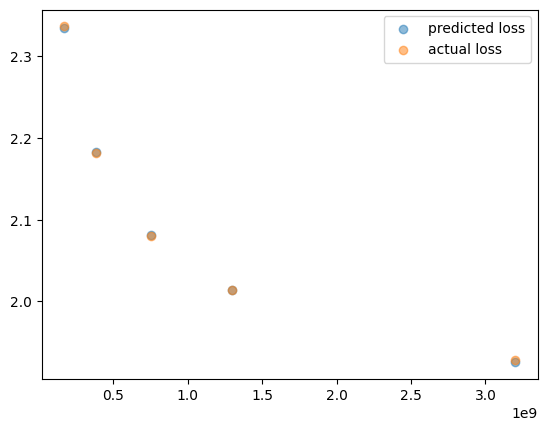

In [97]:
Ns = torch.tensor([0.170, 0.380, 0.750, 1.3, 3.2]) * 10**9
plt.scatter(Ns, infer1(Ns.view(-1, 1), p=P), label="predicted loss", alpha=0.5)
plt.scatter(Ns, actual_loss(Ns), label="actual loss", alpha=0.5)
plt.legend()